### AIN313 Assignment 1
### By Adam Sattout, b2220765061

## Part 1: Throery Questions

In [ ]:
pip install ipython

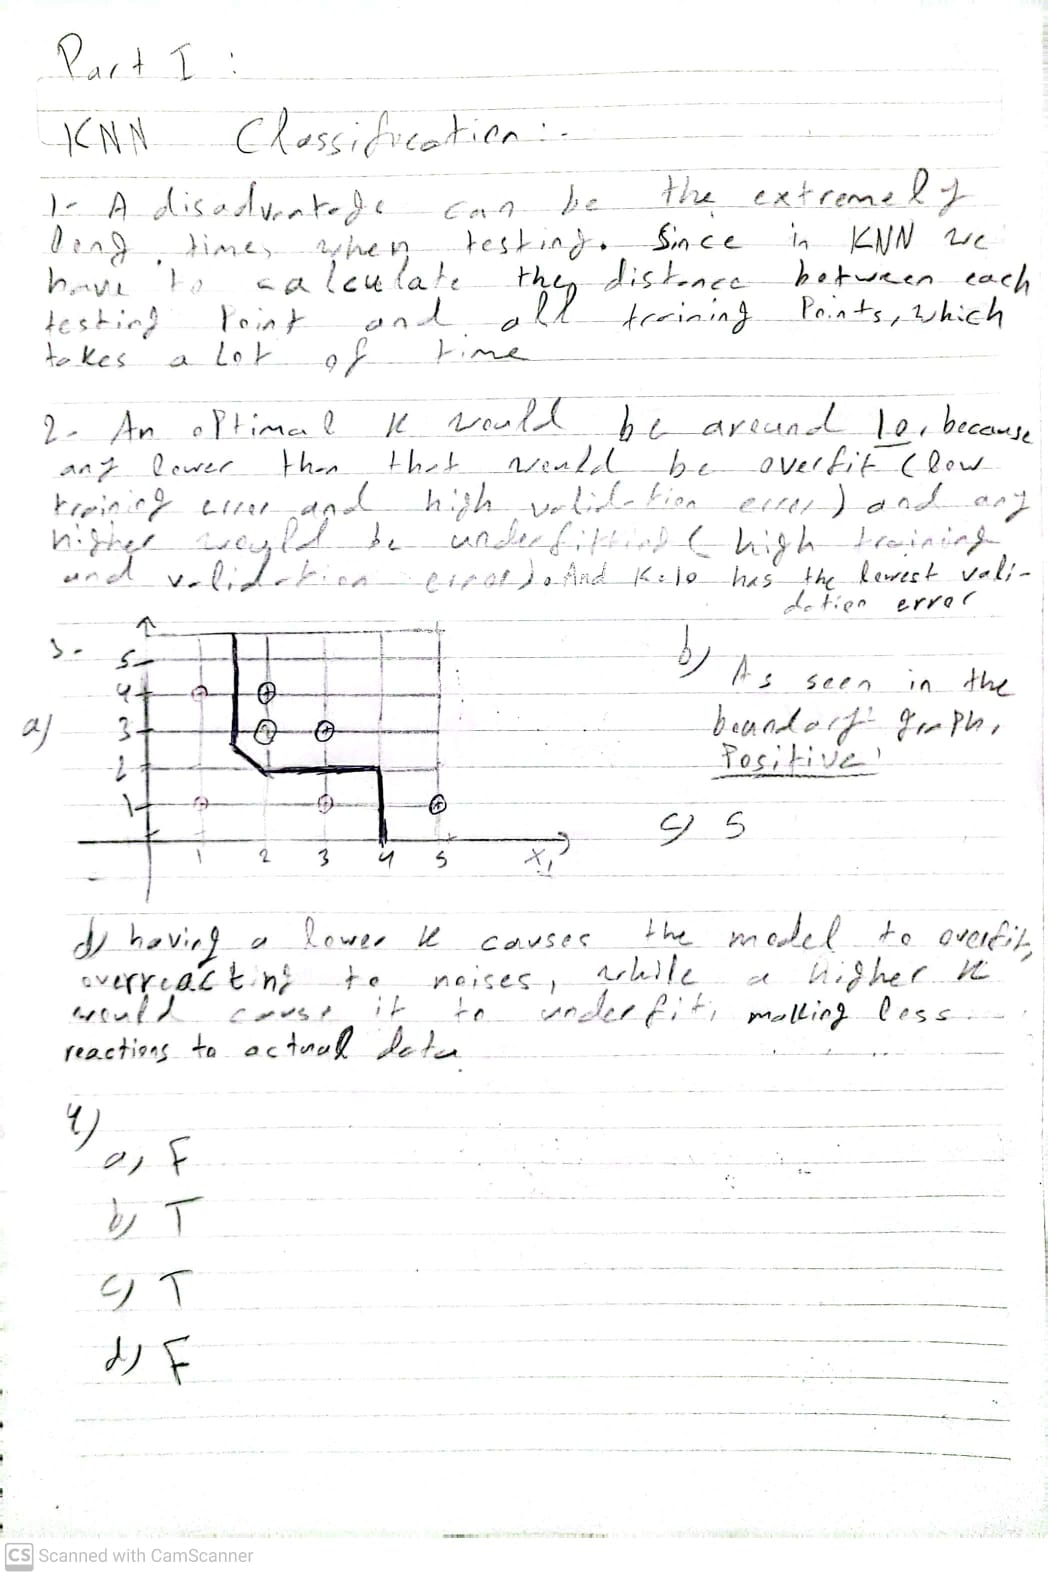

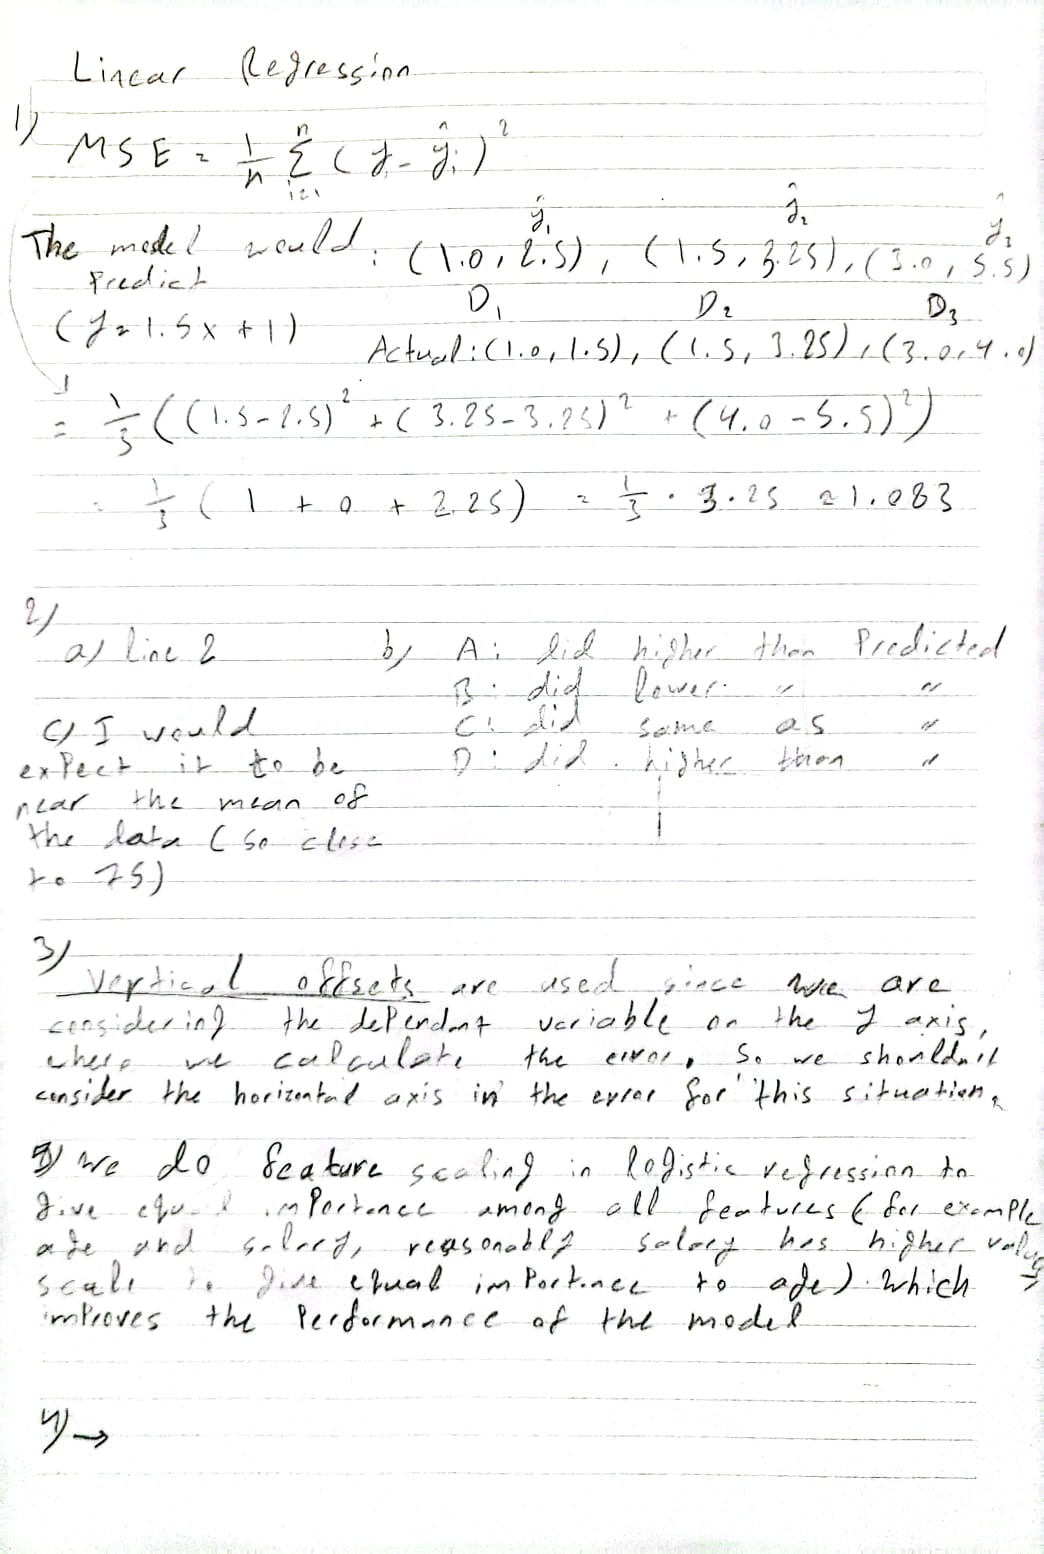

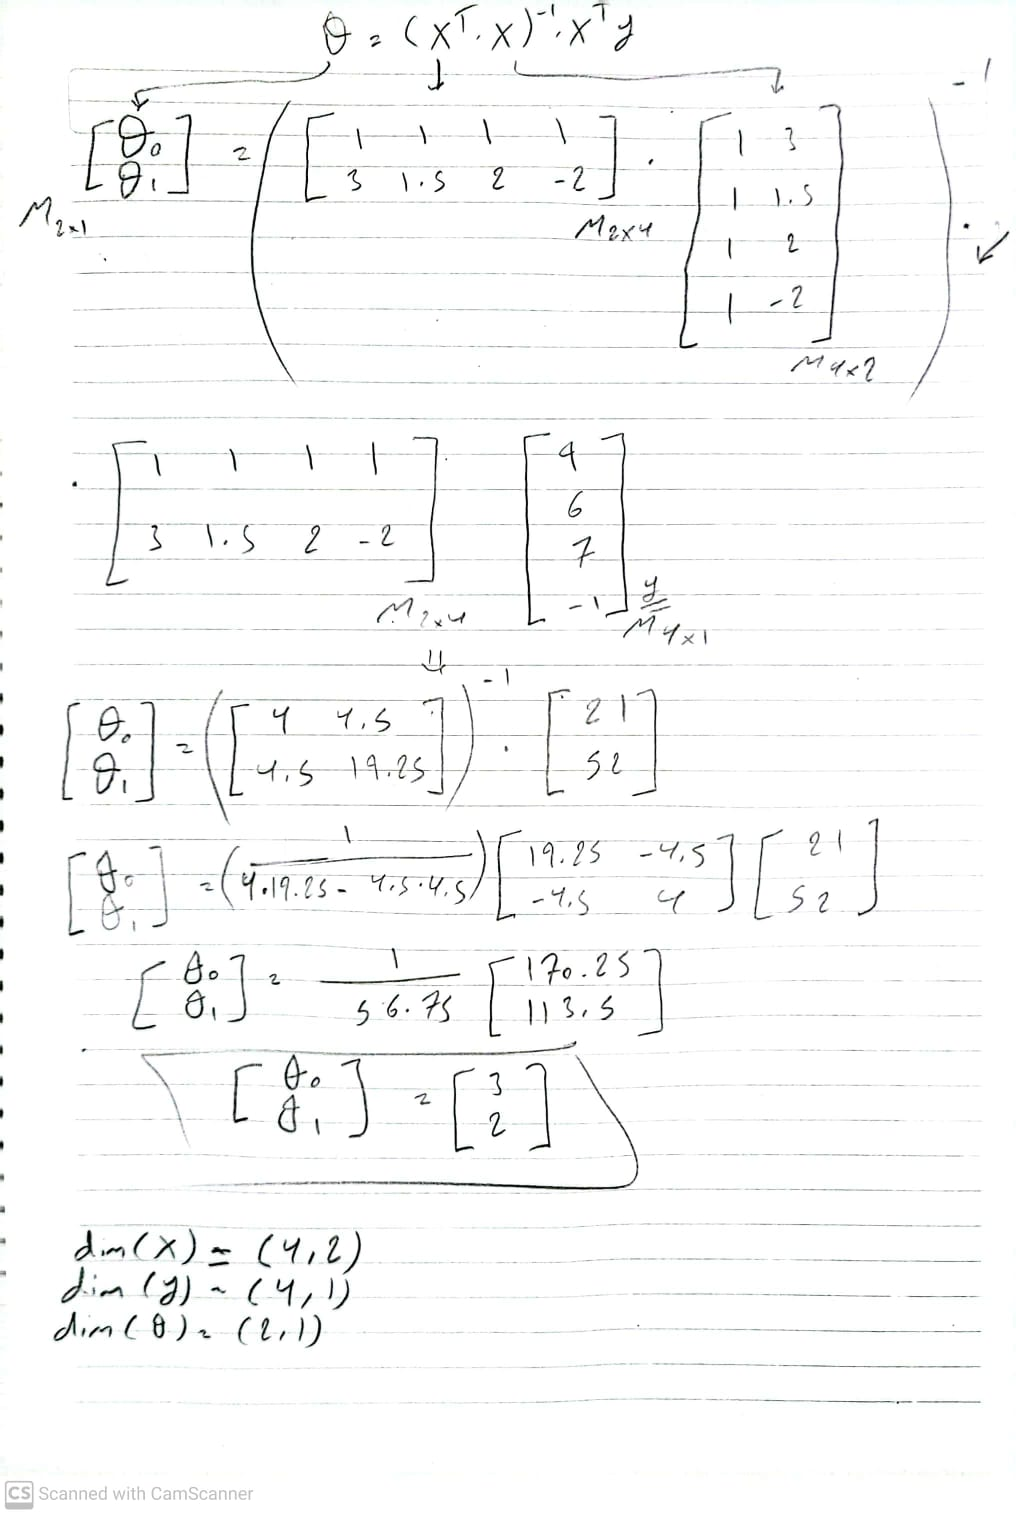

In [31]:
from IPython.display import Image
display(Image(filename='KNN.jpeg')) 
display(Image(filename='LR1.jpeg')) 
display(Image(filename='LR2.jpeg')) 

# Part 2: Telecommunication Customer Classification System

### 1. Preparing the data

We first import the libraries that we are going to use, locate the file and see how our dataframe looks after shuffling

In [ ]:
#pip install commands

pip install pandas
pip install matplotlib
pip install seaborn
pip install scikit-learn
pip install numpy

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

df = pd.read_csv("telecommunicaton_classification.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,district,customer_since,age,is_married,address,salary,ed,employment_status,is_retired,gender,reside,service
0,1,52,62,No,23,36.0,4,17,No,F,1,Fundamental Service
1,1,48,47,No,9,72.0,3,13,No,F,5,Complete Service
2,3,53,38,Yes,15,20.0,3,6,No,M,4,E-Service
3,3,60,45,Yes,23,117.0,4,11,No,F,3,Complete Service
4,3,17,35,No,4,77.0,3,8,No,M,1,Advanced Service


We can see that we have 4 different features that need to be encoded, 3 of which are binary and the target class with 4 classes. We see what the classes are and encode them to numbers

In [68]:
df["service"].unique()

array(['Fundamental Service', 'Complete Service', 'E-Service',
       'Advanced Service'], dtype=object)

In [69]:
df['is_married'] = df['is_married'].replace({'No': 0, 'Yes': 1})
df["gender"] = df["gender"].replace({'F': 1, 'M': 0})
df['is_retired'] = df['is_retired'].replace({'No': 0, 'Yes': 1})
df['service'] = df['service'].replace({'Fundamental Service' : 0, 'Complete Service': 1, 'Advanced Service': 2, 'E-Service': 3})

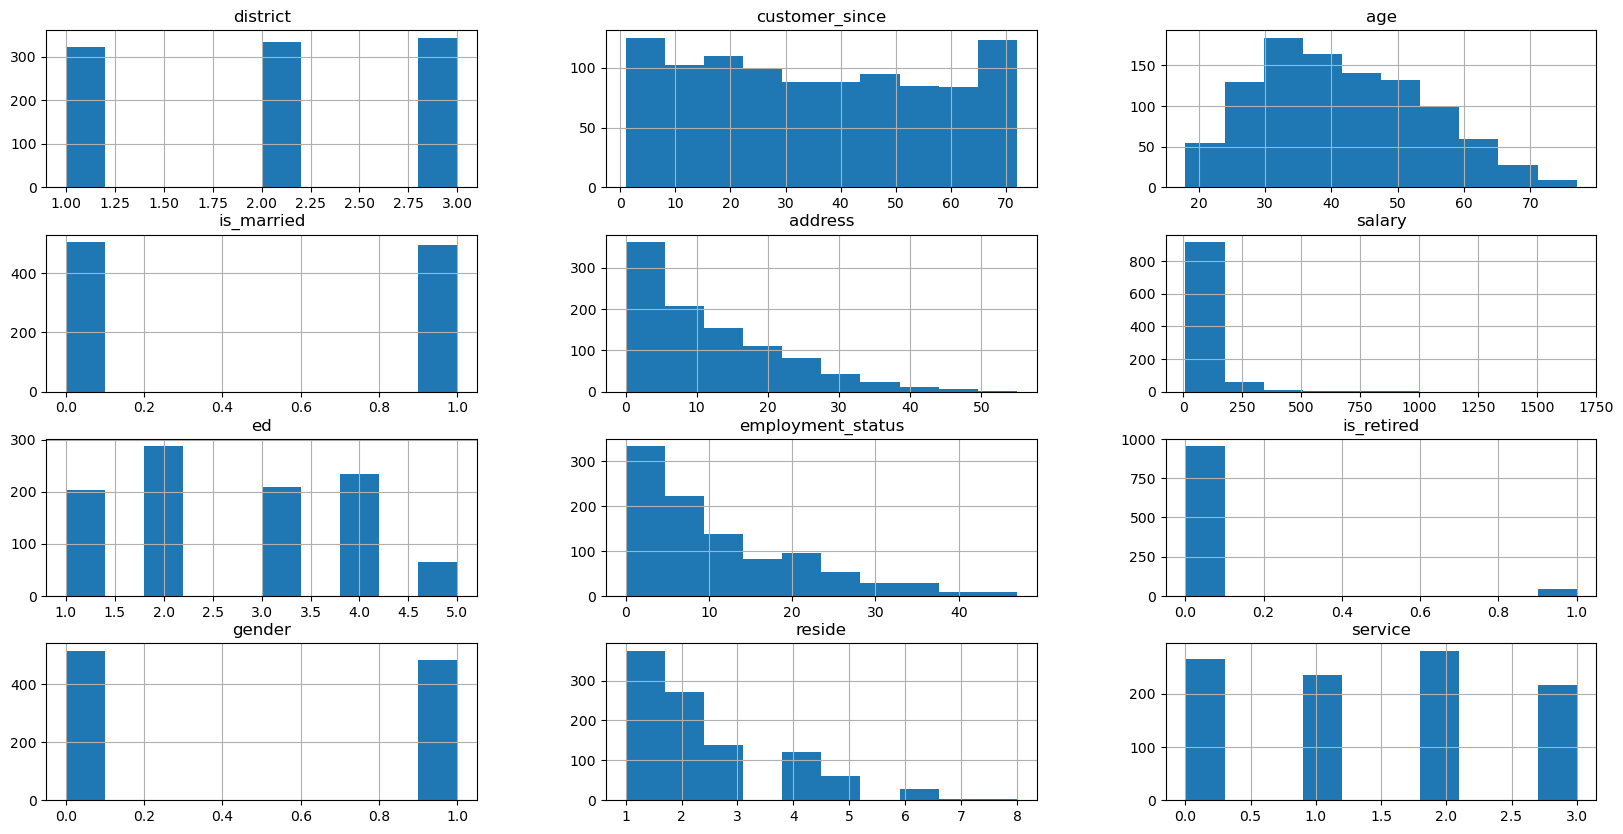

In [70]:
df.hist(bins = 10, figsize=(20, 10))
plt.show()

We can look at the distributions of each feature that we have and we see that for our target feature, we have some balance so we shouldn't be worried about it. Some feature however dont have alot of varience like is_retired and salary so those can be remove to lower the dimensionality of our model.

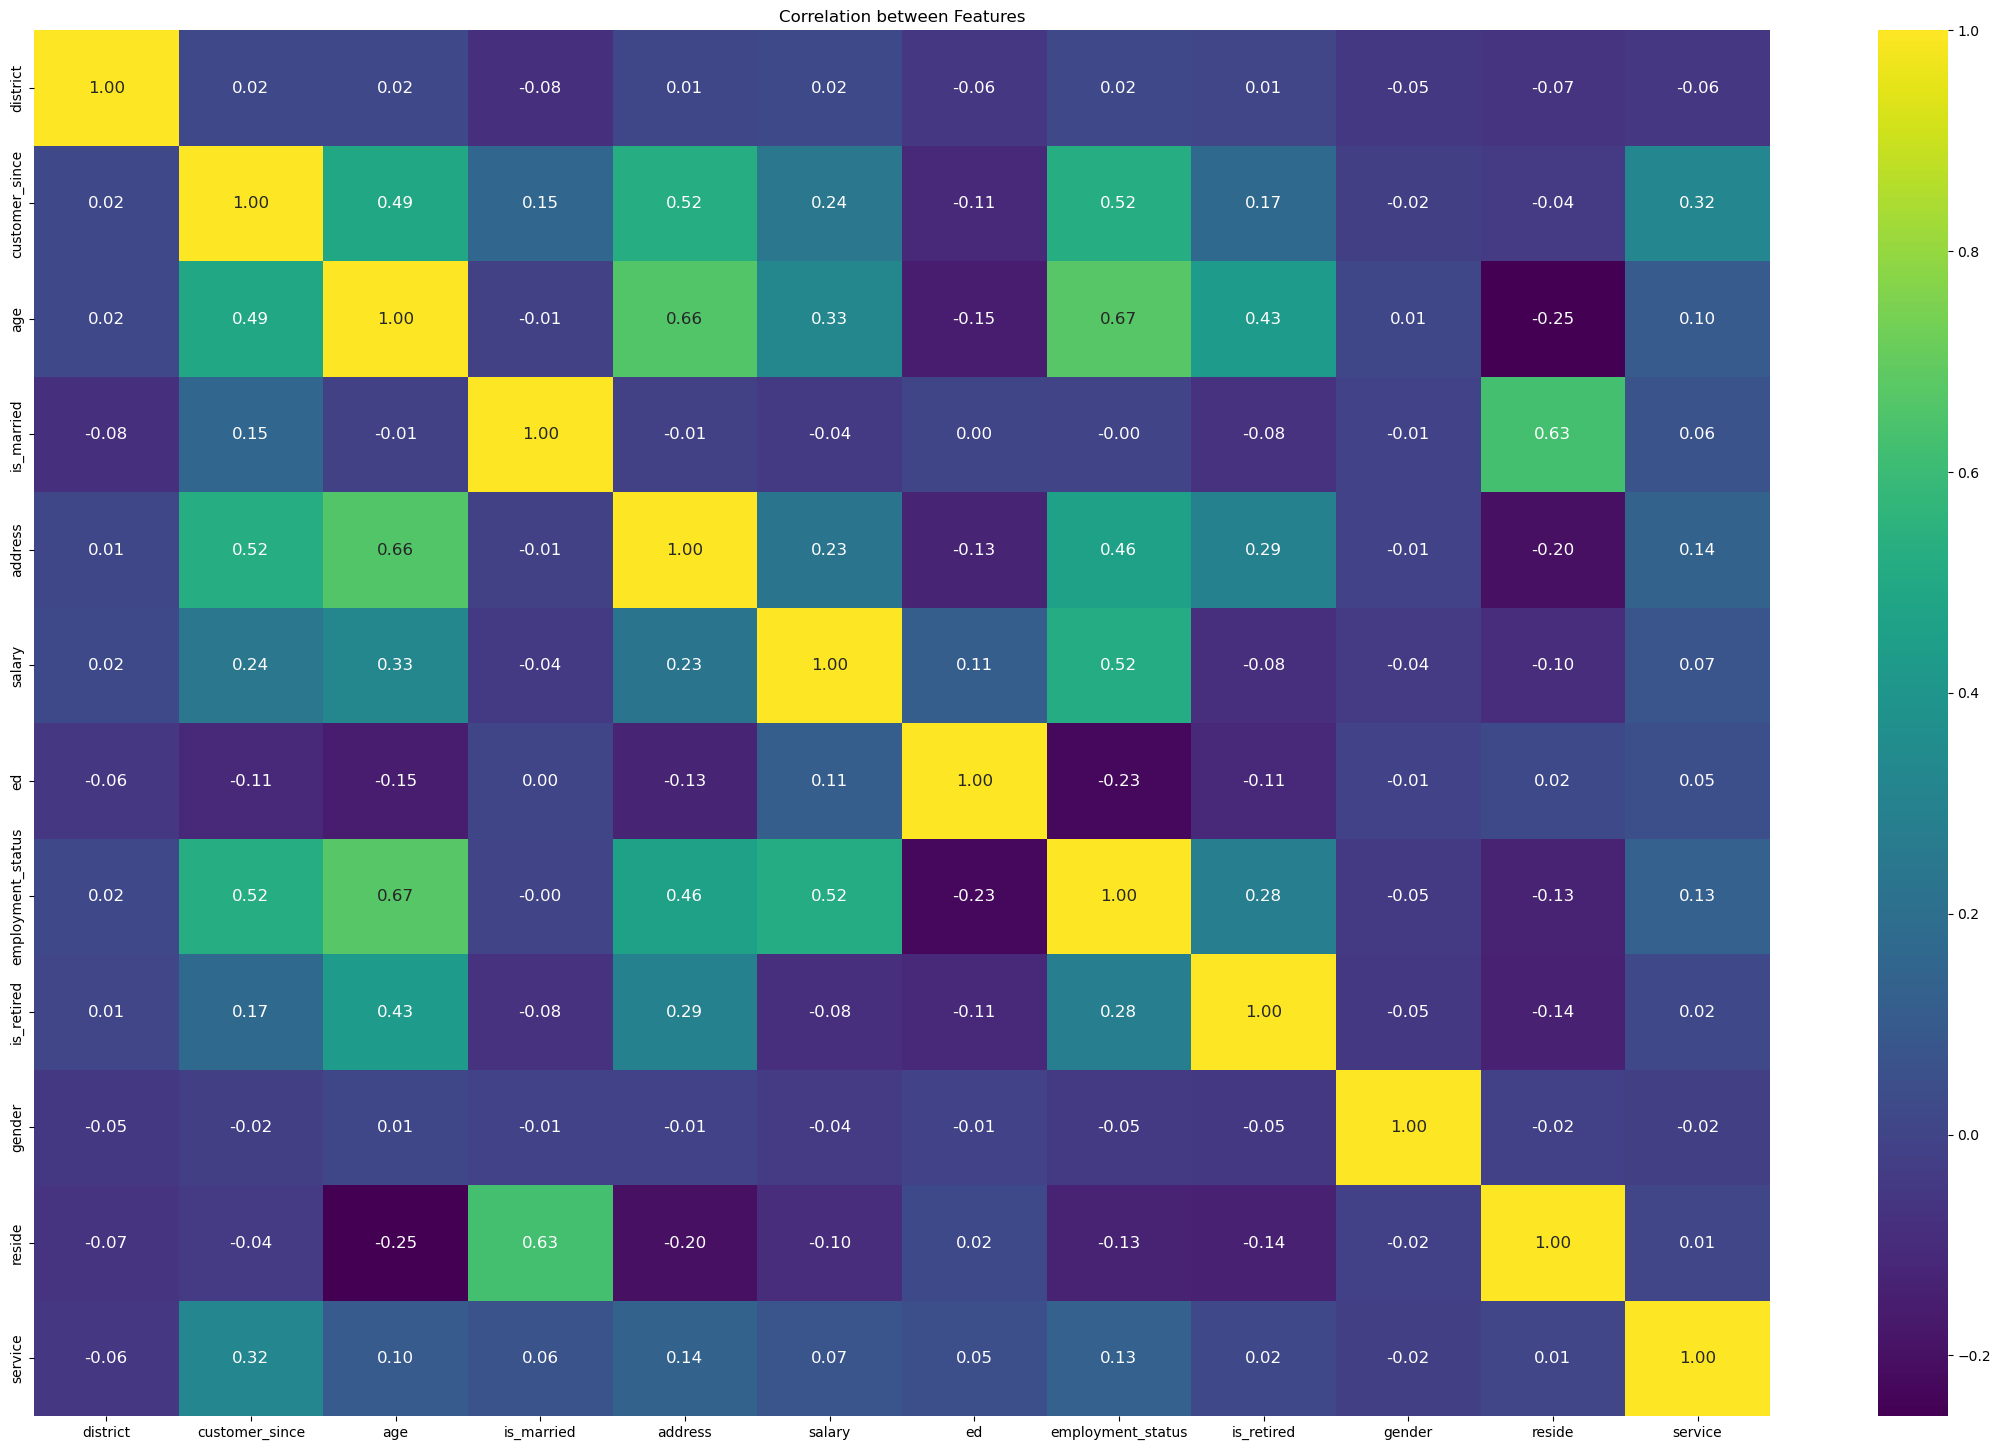

In [71]:
plt.figure(figsize=(28, 18))
sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt=".2f", annot_kws={"size": 12})
plt.title('Correlation between Features')
plt.show()

If we also look at the heatmap showcasing the correlation factor between the features, we can observe some weak tho existing correlations between our independent and target features. with the most effective ones being "customer_since", "address", and "employment_status"

In [72]:
#Create a new copy of the dataframe and normalize it using minmax scaling.

normalizedFeatures = ["district", "customer_since", "age", "address", "salary", "ed", "employment_status", "reside"]
normalizedDf = df.copy()
for feature in normalizedFeatures:
    normalizedDf[feature] = (normalizedDf[feature] - normalizedDf[feature].min()
                            )/(normalizedDf[feature].max() - normalizedDf[feature].min())

We will later test the effect of normalizing the data on the model

In [73]:
#Eliminate features that may be bad for the data

dfCurified = df.drop("is_retired", axis = 1).drop("salary", axis = 1)

We will also test whether removing the features that dont have alot of varience as shown in the histogram will affect the model

In [74]:
targetFeature = 'service'
dfOutliers= df.copy()

for feature in dfOutliers.columns:
    if feature != targetFeature and feature != "id" and dfOutliers[feature].dtype != 'object':
        #Takes only numerical non-target features, calculates the mean value for each feature and imputes it into all the outliers
        mean_value = dfOutliers[feature].mean()
        Q1 = dfOutliers[feature].quantile(0.25)
        Q3 = dfOutliers[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (dfOutliers[feature] < (Q1 - 1.5 * IQR)) | (dfOutliers[feature] > (Q3 + 1.5 * IQR))
        dfOutliers.loc[outlier_mask, feature] = mean_value

In addition to that, we will test the effect of having outliers

### 2. Creating The Model and Helper Functions

In [75]:
#This is a function that splits the dataset into train, test, and if needed validation sets

def splitDataset(df, val = False):
    rowSize = df.shape[0]
    valRatio = 0.15
    if val:
        ratio = 0.7
    else:
        ratio = 0.8

    
    splitValue = int(ratio * rowSize)
    valSplit = splitValue + int(valRatio * rowSize)

    trainX = df[0:splitValue].drop("service", axis = 1)
    trainY = df[0:splitValue]["service"]

    testX = df[splitValue:].drop("service", axis = 1)
    testY = df[splitValue:]["service"]

    splitSets = [trainX, trainY, testX, testY]

    if val:
        valX = df[splitValue:valSplit].drop("service", axis = 1)
        valY = df[splitValue:valSplit]["service"]
        splitSets.append(valX)
        splitSets.append(valY)
        

    return splitSets

In [76]:
#This function will be used when calculating the votes of each class, it changes how much
#a point will factor into a vote based on the knn implementation in question.

def voteCalculator(distance, freq, mode = "standard"):
    if mode == "standard":
        return 1
    elif mode == "distanceWeighted":
        return 1 / distance
    elif mode == "frequencyWeighted":
        return 1 / freq
    elif mode == "combined":
        return (1 / freq) * (1 / distance)

In [77]:
# This function labels any point taken as an input by claculating the distance between
# it and all points in the trainX set using matrix operations. Otherwise, going for the
# standard way of calculating distances one by one will take so much time. Gets the nearest 
# k neighbors, calculates frequencies of each class and based on which knn implementation 
# we are doing, increases the voteFrequencies accordingly and returns the class with max votes.

def labelPoint(k, trainX, trainY, point, p, mode_ = "standard"):
    distances = np.sum(np.abs(trainX - point) ** p, axis=1) ** (1 / p) 
    kNeighbors = np.argsort(distances)[:k]   

    classFrequencies = trainY.value_counts().to_dict()
    voteFrequencies = np.array([0, 0, 0, 0], dtype=float)
    for i in range(k):
        element = kNeighbors[i]
        distance = distances[element]
        classFreq = classFrequencies[trainY[element]]
        voteFrequencies[trainY.iloc[element]] += voteCalculator(distance, classFreq, mode = mode_)

    return voteFrequencies.argmax()

In [78]:
# This is the main KNN method, it goes through the given testX set and uses the mode parameter, which
# specifies how the point K neighbor votes are being calculated after calculating the distances. p is the
# distance metric being used. At the end it returns the predictions.

def KNN(k, testX, trainX, trainY, p, mode = "standard"):
    y = []
    for i in range(testX.shape[0]):
        point = testX.iloc[i]
        label = labelPoint(k, trainX, trainY, point, p, mode)
        y.append(label)

    return y

In [79]:
# At the end we have a simple function to print the metrics and confusion matrix.

def print_metrics(y_pred, y_true):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.2f}")

    # Precision
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Recall: {recall:.2f}\n")

### 3. Applying The Model

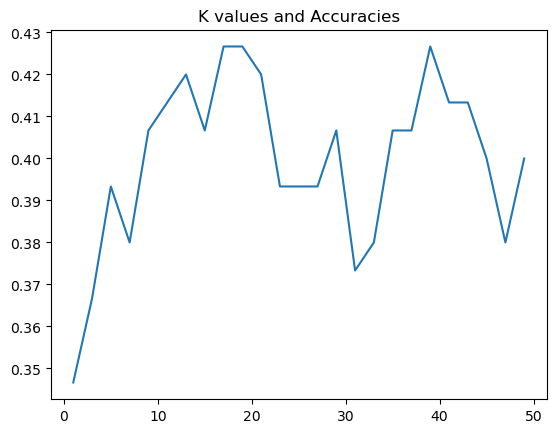

In [88]:
trainX, trainY, testX, testY, valX, valY = splitDataset(df, val=True)

kValues = range(1, 50, 2)
accuracies = []

# Test the standard model on validation set on various k values
for i in kValues:
    preds = KNN(i, valX, trainX, trainY, 1)
    accuracy = accuracy_score(preds, valY)
    accuracies.append(accuracy)

plt.plot(kValues, accuracies)
plt.title("K values and Accuracies")
plt.show()

After we pick odd values for k to limit draw situations, we can plot K to accuracy and see where the model performed the best, and we can see it peeking at k = 17, so we will use that on our test set.

In [97]:
preds = KNN(17, testX, trainX, trainY, 1)
print_metrics(preds, testY)

Confusion Matrix:
[[45  9 15 11]
 [24 16 14  8]
 [29 15 31 15]
 [23 13 18 14]]
Accuracy: 0.35
Precision: 0.35
Recall: 0.35



These are the results of the model, although the results are fairly low, they are still a bit better than pure chance with 25%. This is probably due to the data not being informative enough for the model

In [108]:
# A function that automates the process of splitting the data, running a model and presenting results

def testModel(df, p, titleString, mode = "standard"):
    trainX, trainY, testX, testY, valX, valY = splitDataset(df, val=True)

    kValues = range(1, 50, 2)
    highestAcc = 0
    highestIndex = 0

    for i in kValues:
        preds = KNN(i, valX, trainX, trainY, p, mode)
        accuracy = accuracy_score(preds, valY)
        if accuracy > highestAcc:
            highestIndex = i
            highestAcc = accuracy

    preds = KNN(highestIndex, testX, trainX, trainY, p)
    print(titleString + ":")
    print("Optimal k =", highestIndex)
    print_metrics(preds, testY)

#### 3.1. Unnormalized vs Normalized Data

In [109]:
testModel(df, 1, "Unnormalized")
testModel(normalizedDf, 1, "Normalized")

Unnormalized:
Optimal k = 17
Confusion Matrix:
[[45  9 15 11]
 [24 16 14  8]
 [29 15 31 15]
 [23 13 18 14]]
Accuracy: 0.35
Precision: 0.35
Recall: 0.35

Normalized:
Optimal k = 43
Confusion Matrix:
[[49 10 18  3]
 [22 23  6 11]
 [33 15 36  6]
 [24 16 20  8]]
Accuracy: 0.39
Precision: 0.38
Recall: 0.39



We can see a slight increase in out results after normalizing, which is expected since KNN is heavily dependant on distance, and normalizing all the inputs to be between 0 and 1 is a huge benefit to not give higher importance to features with larger values.

#### 3.2. Eliminated vs Row Data

In [110]:
testModel(df, 1, "Raw Data")
testModel(dfCurified, 1, "Eliminated")

Raw Data:
Optimal k = 17
Confusion Matrix:
[[45  9 15 11]
 [24 16 14  8]
 [29 15 31 15]
 [23 13 18 14]]
Accuracy: 0.35
Precision: 0.35
Recall: 0.35

Eliminated:
Optimal k = 13
Confusion Matrix:
[[43 18 14  5]
 [21 20 10 11]
 [32 25 28  5]
 [20 20 14 14]]
Accuracy: 0.35
Precision: 0.37
Recall: 0.35



We can see a low increase in precision when we eliminate the features with little to no varience. And this supports many models and specifically KNN being highly affected by the curse of dimensionality, where we need a lot of additional data to compensate for each feature added exponentially! So removing any unnessecary features will help our model deal with the little data that it has 

#### 3.3. Outlier Handled vs Non-Outlier Handled

In [111]:
testModel(df, 1, "Outlier Not Handled")
testModel(dfOutliers, 1, "Outlier Handled")

Outlier Not Handled:
Optimal k = 17
Confusion Matrix:
[[45  9 15 11]
 [24 16 14  8]
 [29 15 31 15]
 [23 13 18 14]]
Accuracy: 0.35
Precision: 0.35
Recall: 0.35

Outlier Handled:
Optimal k = 13
Confusion Matrix:
[[43 14  9 14]
 [22 21 12  7]
 [31 17 27 15]
 [26 14 14 14]]
Accuracy: 0.35
Precision: 0.35
Recall: 0.35



We can see that there is not really a difference between the tests. This is probably due to the dataset not really having much outliers as seen in the distributions drawn before, tho this step can be beneficial in a real world scenario.

#### 3.4. Different KNN Implementaions

In [113]:
#Using NormalizedDf for better results

testModel(normalizedDf, 1, "Standard", "standard")
testModel(normalizedDf, 1, "Distance Weighted", "distanceWeighted")
testModel(normalizedDf, 1, "Frequency Weighted", "frequencyWeighted")
testModel(normalizedDf, 1, "Combination Weighted", "combined")

Standard:
Optimal k = 43
Confusion Matrix:
[[49 10 18  3]
 [22 23  6 11]
 [33 15 36  6]
 [24 16 20  8]]
Accuracy: 0.39
Precision: 0.38
Recall: 0.39

Distance Weighted:
Optimal k = 31
Confusion Matrix:
[[51  9 17  3]
 [23 22  6 11]
 [29 15 39  7]
 [23 16 23  6]]
Accuracy: 0.39
Precision: 0.37
Recall: 0.39

Frequency Weighted:
Optimal k = 25
Confusion Matrix:
[[46 13 19  2]
 [21 22  9 10]
 [29 13 36 12]
 [19 19 22  8]]
Accuracy: 0.37
Precision: 0.36
Recall: 0.37

Combination Weighted:
Optimal k = 31
Confusion Matrix:
[[51  9 17  3]
 [23 22  6 11]
 [29 15 39  7]
 [23 16 23  6]]
Accuracy: 0.39
Precision: 0.37
Recall: 0.39



Again, we can see the different methods having very close results. However, in a dataset that isn't balanced, using weighted KNN can have a significant benefit over regular KNN due to giving importance to how close and how much of a class there is. Nonetheless, regular KNN can have better results over distance weighted KNN in cases where there is a lot of noise, which might slightly be the case here

#### 3.5. Different Distance Metrics

In [117]:
testModel(normalizedDf, 2, "p = 2")
testModel(normalizedDf, 10, "p = 10")
testModel(normalizedDf, 25, "p = 25")

p = 2:
Optimal k = 39
Confusion Matrix:
[[46 11 17  6]
 [18 22  8 14]
 [33 10 37 10]
 [20 16 22 10]]
Accuracy: 0.38
Precision: 0.37
Recall: 0.38

p = 10:
Optimal k = 27
Confusion Matrix:
[[42 11 21  6]
 [20 28  6  8]
 [33 17 32  8]
 [21 15 21 11]]
Accuracy: 0.38
Precision: 0.37
Recall: 0.38

p = 25:
Optimal k = 25
Confusion Matrix:
[[45 11 19  5]
 [19 28  6  9]
 [32 17 35  6]
 [19 14 22 13]]
Accuracy: 0.40
Precision: 0.40
Recall: 0.40



A larger p value usually makes the big distances more significant, which in turn makes gives less variant features less importance, which might be the reason to the largest p having the best results. 